In [1]:
import os
import sys
from os import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
import json
import argparse
from scipy.optimize import least_squares
import coord_helper as ch
import h5py
import importlib
from skyfield.api import load, EarthSatellite, Topos, wgs84

BDC is using numpy


In [2]:
config_file_name1 = 'config_24_07.json'
config_file_name2 = 'config_25_07.json'
baseline_idx =1 
working_directory = '/project/s/sievers/thomasb/mars_data_24/4bit'
day1 = '24_07'
day2 = '25_07'

In [3]:
with open(f"{working_directory}/{day1}/{config_file_name1}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time1 = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)
print(global_start_time1)

Antenna Paths: ['/scratch/s/sievers/mohanagr/mars1_2024/baseband/', '/scratch/s/sievers/mohanagr/mars2_2024/baseband/']
Antenna Coordinates: [[79.41718333333333, -90.76735, 189], [79.41721666666666, -90.75885, 176]]
Visibility Accumulation Length 30000
Coarse Accumulation Length: 1000000
1721797200


In [96]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path = dir_parents[0]
a2_path = dir_parents[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path1 = outils.get_tle_file(global_start_time1, "/project/s/sievers/mohanagr/OCOMM_TLES")
tle_path2 = outils.get_tle_file(global_start_time2, "/project/s/sievers/mohanagr/OCOMM_TLES")


context = [visibility_window, T_SPECTRA, v_acclen, v_nchunks, ref_coords]
print(context)

[1000, 1.6384e-05, 30000, 2034, [79.41718333333333, -90.76735, 189]]


<p style="color: blue; font-size: 25px;">Unpack All Pulses</p>


In [36]:
observed_data = []
info = []


#with h5py.File(f'vis_all_{global_start_time}_10hrs.h5', 'r') as f:

with h5py.File(f'{working_directory}/{day1}/visraw_bline1_{global_start_time1}.h5', 'r') as f:
    for p in f:
        pulse_info = []
        pulse_info.append(p)
        pulse_info.append([int(f[p].attrs['start_time']), int(f[p].attrs['end_time']), int(f[p].attrs['global_start_time'])])
        pulse_info.append(json.loads(f[p].attrs['sats']))
        pulse_info.append(f[p].attrs['tle_path'])
        info.append(pulse_info)

        data = f[f'/{p}'][:]
        observed_data.append(data)

print(info)

#possible to-do here is to order them by start time. but might not really matter.

[['0_0', [0, 160, 1721797200], {'33591': [1839, 1850]}, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], ['1_3520', [3520, 3915, 1721797200], {'28654': [1836, 1837]}, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], ['2_7755', [7755, 8070, 1721797200], {'59051': [1836, 1837]}, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], ['3_9805', [9805, 9945, 1721797200], {'28654': [1836, 1837]}, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], ['4_13775', [13775, 14240, 1721797200], {'59051': [1836, 1837]}, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], ['5_19805', [19805, 20335, 1721797200], {'59051': [1836, 1837]}, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt']]


<p style="color: blue; font-size: 25px;">Filter for Good Pulses</p>


In [101]:
info_dict = {}
importlib.reload(ch)

<module 'coord_helper' from '/home/s/sievers/thomasb/albatros_analysis/scripts/orbcomm/fitting/coord_helper.py'>

In [91]:
pulse_idx = 0
print(info[pulse_idx])

['0_0', [0, 160, 1721797200], {'33591': [1839, 1850]}, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt']


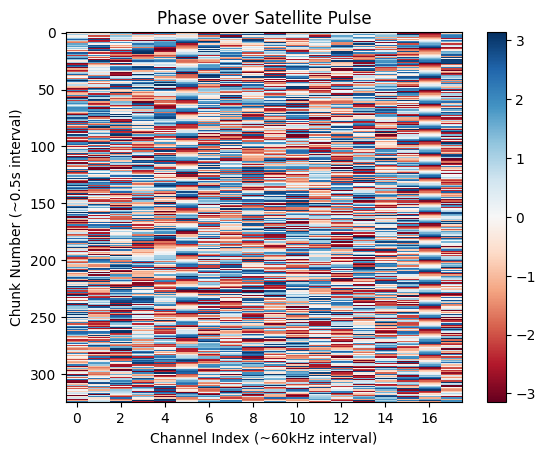

In [92]:
#plot wrapped here, and then after plot the unwrapped version
vis_phase = observed_data1[pulse_idx]
plt.xlabel("Channel Index (~60kHz interval)")
plt.ylabel("Chunk Number (~0.5s interval)")
plt.title("Phase over Satellite Pulse")
plt.imshow(vis_phase[:,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

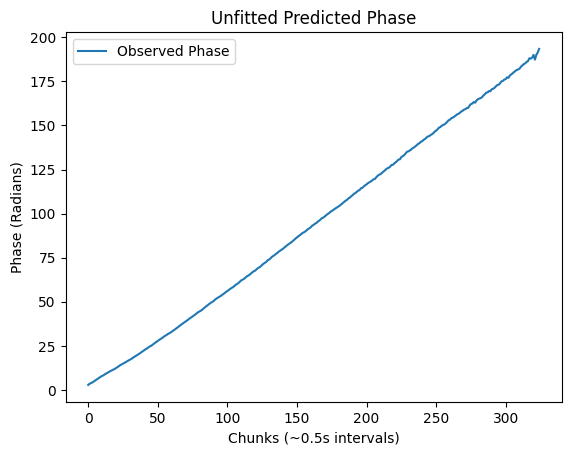

In [114]:
chan = 16
plt.plot(np.unwrap(vis_phase[:,chan]), label="Observed Phase")
plt.xlabel("Chunks (~0.5s intervals)")
plt.ylabel("Phase (Radians)")
plt.title("Unfitted Predicted Phase")
plt.legend()

In [115]:
chan_big = 1850
tle_path = info[pulse_idx][3]
satID = int(list(info[pulse_idx][2].keys())[0])
print(satID)
times = info[pulse_idx][1]

33591


catalog #33591 epoch 2024-07-24 21:36:39 UTC


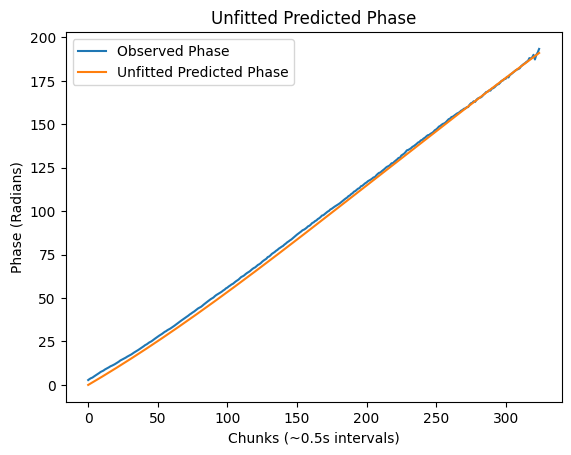

In [116]:
plt.plot(np.unwrap(vis_phase[:,chan]), label="Observed Phase")
plt.plot(ch.phase_pred_manual(a2_coords, times, satID, chan_big, tle_path, context), label="Unfitted Predicted Phase")
plt.xlabel("Chunks (~0.5s intervals)")
plt.ylabel("Phase (Radians)")
plt.title("Unfitted Predicted Phase")
plt.legend()

In [113]:
good_pulse_idxs1 = [ 2, 4, 7, 11, 12, 17, 20, 24, 25, 27]
importlib.reload(ch)

<module 'coord_helper' from '/home/s/sievers/thomasb/albatros_analysis/scripts/orbcomm/fitting/coord_helper.py'>

In [38]:
pulse_data1 = [observed_data1[i] for i in good_pulse_idxs1]
pulse_info1 = [info1[i] for i in good_pulse_idxs1]
print(pulse_info1)
print(pulse_info1[0][0])

[[17005, 17530, 59051, 1836, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [22070, 22425, 25338, 1841, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [23025, 23570, 59051, 1837, 48959, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [27945, 28075, 33591, 1850, 109994, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [28275, 28555, 25338, 1841, 86569, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [31685, 31985, 28654, 1836, 48958, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [34005, 34085, 33591, 1850, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [4950, 5270, 59051, 1837, 109993, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [7000, 7145, 28654, 1836, 109993, 1721800002, '/project/s/sievers/mohanagr/OCOM

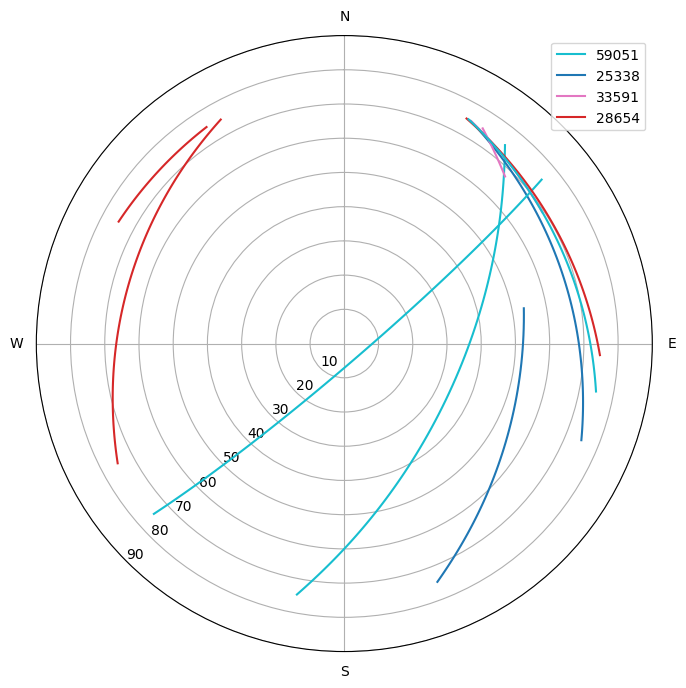

In [46]:
ch.satpass_plotter(pulse_info1, a2_coords)

In [ ]:
with h5py.File(f'{working_directory}/{day1}/vis_selected_bline{baseline_idx}_{global_start_time}.h5', 'w') as f:
    for pulse_idx, observed in enumerate(pulse_data1):
        pulse_array = f.create_dataset(f'{pulse_idx}_{start_time}', data=observed)

        pulse_array.attrs['start_time'] = pulse_info1[pulse_idx][0][0]
        pulse_array.attrs['end_time'] = pulse_info1[pulse_idx][0][1]
        pulse_array.attrs['global_start_time'] = pulse_info1[pulse_idx][0][2]
        pulse_array.attrs['sat'] = pulse_info1[pulse_idx[1][0]]
        pulse_array.attrs['chan'] = pulse_info1[pulse_idx[1][1]]
        pulse_array.attrs['tle_path'] = info[pulse_idx][2]

    f.attrs["vis_window"] = visibility_window
    f.attrs["v_acclen"] = v_acclen
    f.attrs["T_SPECTRA"] = V_T_ACCLEN
    f.attrs["v_nchunks"] = v_nchunks
    f.attrs["ref_coords"] = ref_coords #necessary?
    f.attrs["baseline_idx"] = baseline_idx

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC


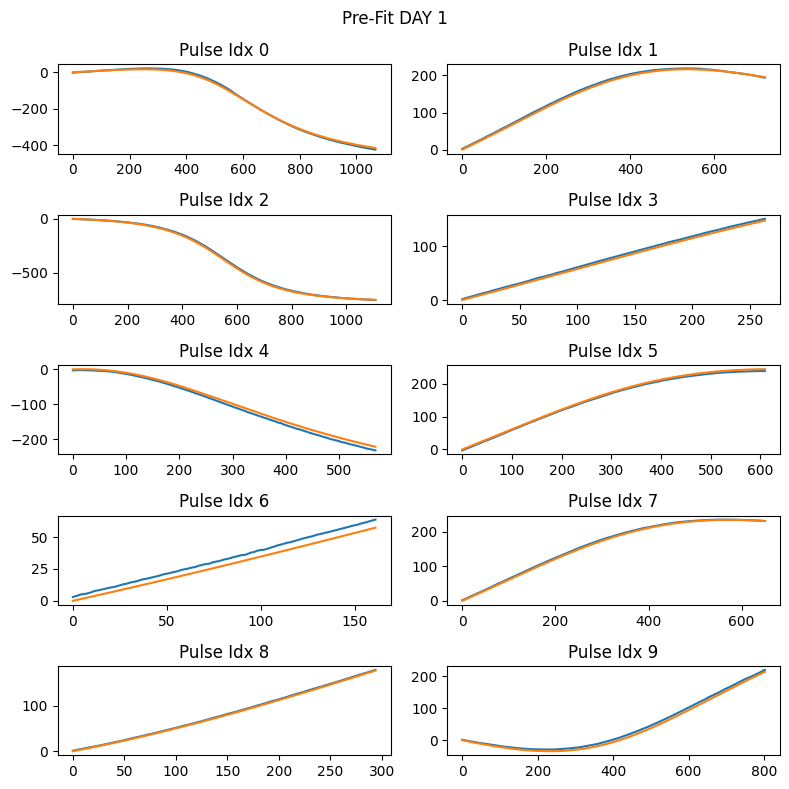

In [41]:
fig, ax = plt.subplots(int(np.ceil(len(pulse_data1)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit DAY 1")
for pulse_idx in range(len(pulse_data1)):
    predicted_data = ch.phase_pred(a2_coords, pulse_idx, pulse_info1, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data1[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

In [47]:
good_pulse_idxs2 = [0, 2, 4, 7, 8, 11,26, 28, 29, 30, 36, 38]

In [50]:
pulse_data2 = [observed_data2[i] for i in good_pulse_idxs2]
pulse_info2 = [info2[i] for i in good_pulse_idxs2]

[array([ 2.53411674e+00,  2.82585335e+00,  3.25009274e+00,  3.78931141e+00,
        4.10966301e+00,  4.45438766e+00,  4.73529339e+00,  5.12023306e+00,
        5.71800518e+00,  5.95724440e+00,  6.30353785e+00,  6.63067865e+00,
        7.07477760e+00,  7.58477497e+00,  7.95300961e+00,  8.23519325e+00,
        8.64530373e+00,  8.98466396e+00,  9.26741219e+00,  9.40116692e+00,
        9.99825764e+00,  1.02815361e+01,  1.09637165e+01,  1.13956585e+01,
        1.17252741e+01,  1.19378567e+01,  1.22213087e+01,  1.26034250e+01,
        1.33797569e+01,  1.37973003e+01,  1.41788445e+01,  1.43662577e+01,
        1.45922375e+01,  1.47697430e+01,  1.49975548e+01,  1.57907248e+01,
        1.58453951e+01,  1.60872707e+01,  1.63262253e+01,  1.68739014e+01,
        1.74626026e+01,  1.78336296e+01,  1.83206310e+01,  1.85615711e+01,
        1.85933857e+01,  1.87703953e+01,  1.96713409e+01,  2.05013218e+01,
        2.07065220e+01,  2.09963436e+01,  2.14761295e+01,  2.17356434e+01,
        2.18372593e+01, 

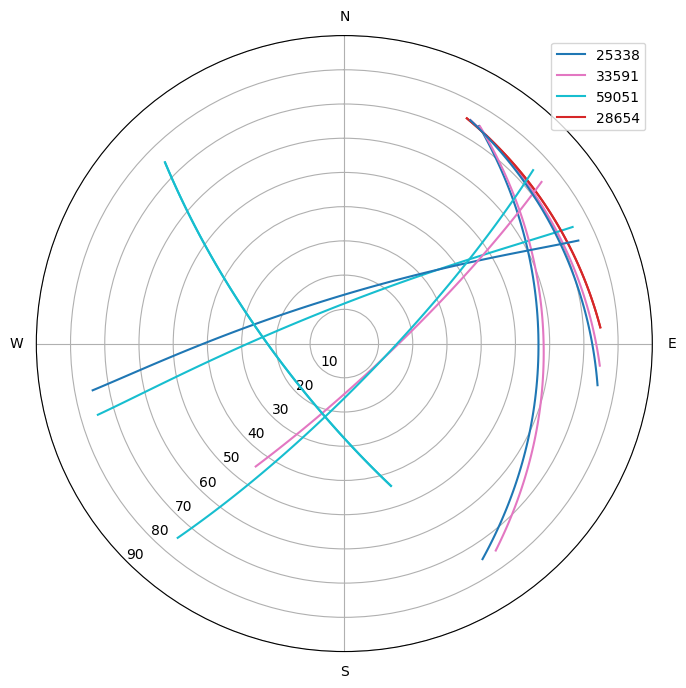

In [51]:
ch.satpass_plotter(pulse_info2, a2_coords)

catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC


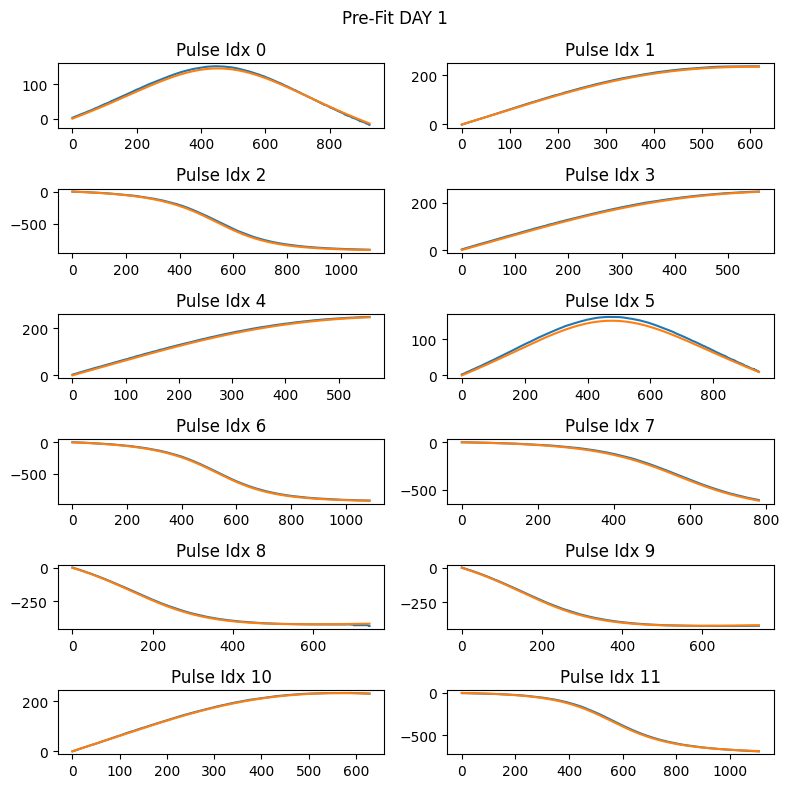

In [17]:
fig, ax = plt.subplots(int(np.ceil(len(pulse_data2)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit DAY 1")
for pulse_idx in range(len(pulse_data2)):
    predicted_data = ch.phase_pred(a2_coords, pulse_idx, pulse_info2, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data2[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

<p style="color: blue; font-size: 25px;">Combine for All Good Pulses</p>


In [55]:
pulse_info = pulse_info1 + pulse_info2
pulse_data = pulse_data1 + pulse_data2

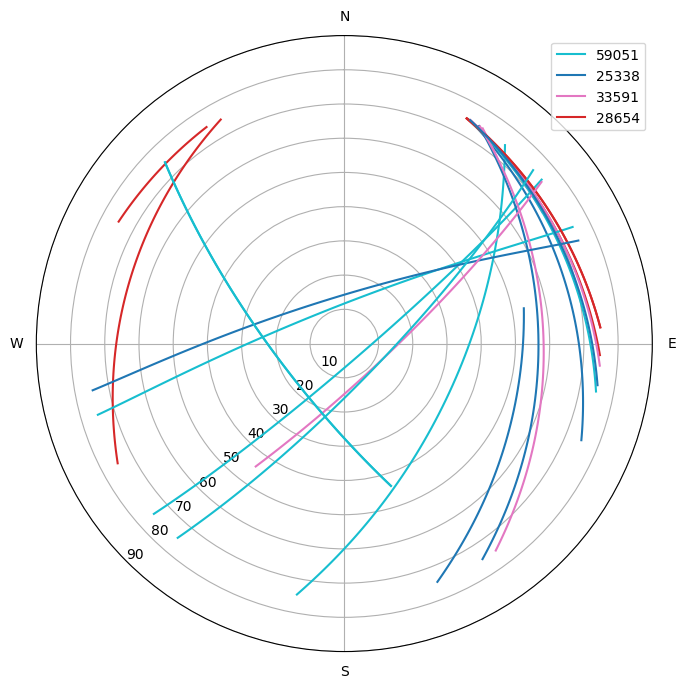

In [56]:
importlib.reload(ch)
ch.satpass_plotter(pulse_info, a2_coords)

<p style="color: blue; font-size: 25px;">Fit</p>


In [57]:
fit = ch.fitting_all(pulse_data, [79.41722193, -90.75888013, 182.76248769], ch.phase_pred, pulse_info, context, method='trf')[0]

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #5

In [58]:
print(fit)

[ 79.41722341 -90.75885658 183.41504506]


In [61]:
fuzzed_coords = ch.make_fuzzed_coords([79.41722341, -90.75885658, 183.41504506], meters=100, reps=5)

In [63]:
fuzzed_fits = []
for coord in fuzzed_coords:
    fuzzed_fit = ch.fitting_all(pulse_data, coord, ch.phase_pred, pulse_info, context, method='trf')[0]
    fuzzed_fits.append(fuzzed_fit)

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #5

In [22]:
fit2 = ch.fitting_all_with_offsets(pulse_data, [79.41722193, -90.75888013, 182.76248769], ch.phase_pred, pulse_info, context, method='trf')[0]

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #5

In [25]:
print(fit2)

[ 79.41722441 -90.75887708 182.94474125]


In [26]:
ch.distance_calculator(fit, fit2)

(0.43284279741573656, 0.4703038089749043)

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC


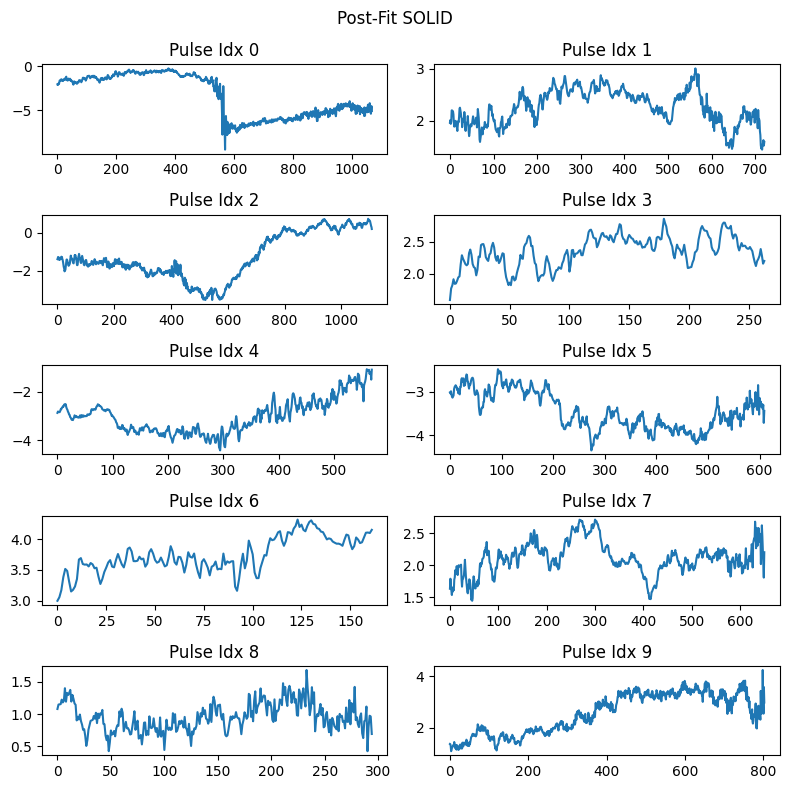

In [21]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Post-Fit SOLID")
for pulse_idx in range(10):
    predicted_data = ch.phase_pred(solid, pulse_idx, pulse_info, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data[pulse_idx] - predicted_data)
plt.tight_layout()

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC


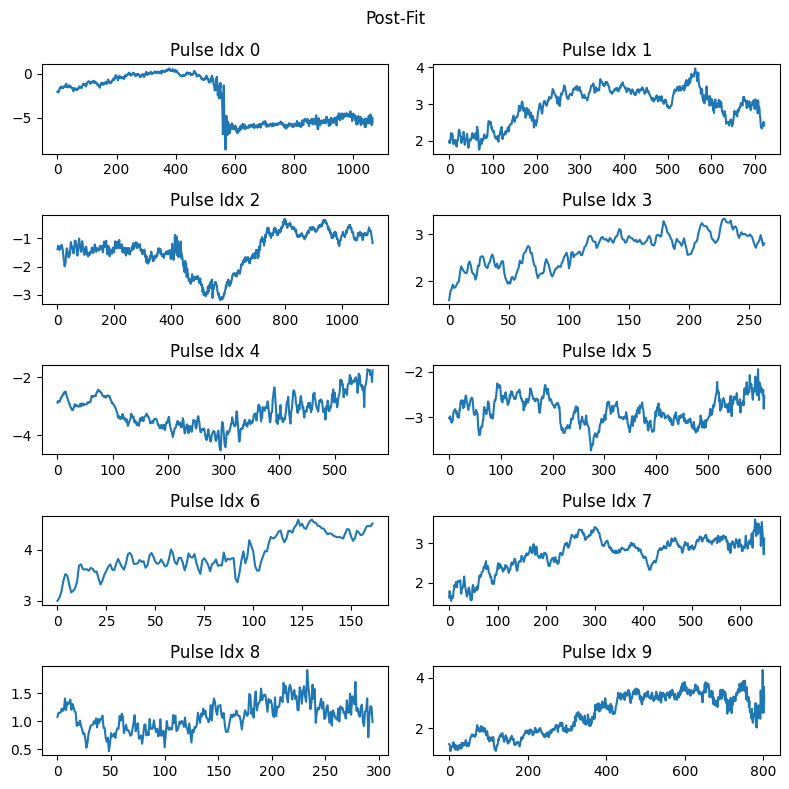

In [34]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Post-Fit")
for pulse_idx in range(10):
    predicted_data = ch.phase_pred(phased, pulse_idx, pulse_info, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data[pulse_idx] - predicted_data)
plt.tight_layout()